In [43]:
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import cv2
from myshow import myshow
from scipy import linalg
from scipy.io import loadmat, savemat
import sys

sys.path.append('include')
import cardiacDicomGlobals as cdg
import reconPipelineFunctions as recon
import validationPipelineFunctions as validate

%matplotlib inline


def closestIndex(f, faxis):
    return np.argmin(np.abs(faxis-f))

In [44]:
patientIndex = 1
currentPatient = cdg.patientList[patientIndex]

doGlobalFreqSearch = False
multiCoilProcessing = False # index of the one we have to do SOS on
channelList = [5,6,7]
#0 good bicarb
#2: good pyruvate ex
#3: good pyruvate ex !!
#7 good bicarb

Generate the frequency axis. Make sure this is identical to that used in the matlab script. Currently we're going from -45 to 45 in steps of 5

In [45]:
fmin = -45
fmax = 45
df = 5
nf = int((fmax - fmin)/df + 1)
freqAxis = np.linspace(fmin, fmax, nf)

gfmin = -15
gfmax = 15
ngf = int((gfmax - gfmin)/df + 1)
globalFreqSearch = np.linspace(gfmin, gfmax, ngf) 

globalOnResInd = cdg.closestIndex(0, globalFreqSearch)
onResInd = closestIndex(0, freqAxis)


Determine the MFI coefficcients. This uses the frequency axis plus the time axis stores in the waveform mat file. From the article "Multifrequency Interpolation for Fast Off-resonance Correction," images are reconstructed by 
\begin{equation*}
I_{cp}\approx \sum_{i=1}^{L}\, c_i(\Delta\omega(\vec{r}))I_i(\vec{r})
\end{equation*}
where the $I_i(\vec{r}$ isthe image reconstructed at frequency $i$, and $c_i(\Delta\omega(\vec{r}))$ are the MFI coefficients. The coefficients are solutions to 
\begin{equation*}
e^{-j \Delta\omega t_k}
\approx \sum_{i=1}^{L}\, c_i(\Delta\omega(\vec{r}))e^{-j \Delta\omega_i t_k}
\end{equation*}
This equation is solved for via least squares

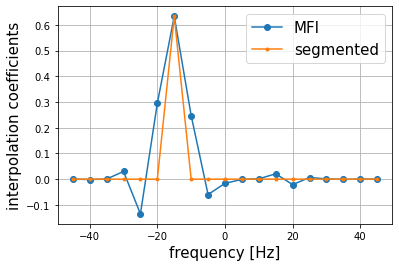

In [46]:

cjmat = recon.generateMFICoefficients(freqAxis, currentPatient)
        
sampleF = 6
segmentedCoeffs = np.zeros(nf)
segmentedCoeffs[sampleF] = np.real(cjmat[sampleF,:]).max()

fs = 15
fig, axes = plt.subplots()

axes.plot(freqAxis, np.real(cjmat[sampleF,:]),'o-', label='MFI')
axes.plot(freqAxis, segmentedCoeffs, '.-', label='segmented')
axes.set_xlabel('frequency [Hz]', fontsize=fs)
axes.set_ylabel('interpolation coefficients', fontsize=fs)
axes.legend(fontsize=fs)
axes.grid(True)

fig.savefig('rawFigs/MFI_coeffs.pdf')


Load all the data. 
* From Dicom: B0 maps
* from png image: mask
* from mat files: c13 MFR reconstructions

In [47]:

b0mag = sitk.ReadImage(currentPatient.b0mag)
b0phase = sitk.ReadImage(currentPatient.b0phase)
loc = sitk.ReadImage(currentPatient.loc)
c13 = sitk.ReadImage(currentPatient.c13)

Since the mask is regular png image, we need to give it coordinates. It has identical resolution and header as the localizer, so we copy it from there. SITK needs a 3D array for single slice 2D images, so add that here

In [48]:
maskSITK = recon.getHeartMask(currentPatient, loc)
myshow(maskSITK)

interactive(children=(IntSlider(value=0, description='z', max=0), Output()), _dom_classes=('widget-interact',)…



process B0 map. For now just apply median filter

(-0.5, 63.5, 63.5, -0.5)

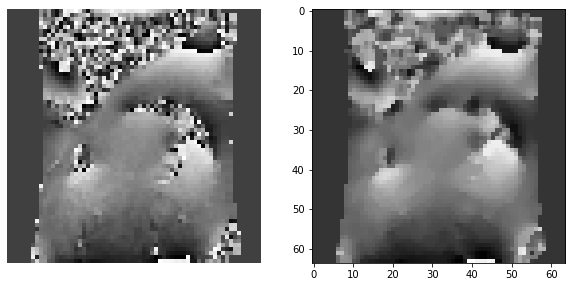

In [49]:
b0phasef, b0phasePixels, medianFiltered = recon.filterB0Map(b0phase)
    
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.imshow(b0phasePixels, cmap='gray')
ax2.imshow(medianFiltered, cmap='gray')
ax1.axis('off')


In [50]:
myshow(loc)

interactive(children=(IntSlider(value=0, description='z', max=0), Output()), _dom_classes=('widget-interact',)…

resample to c13 target image

In [51]:
b0phase_r = recon.resampleSITKImage(c13,b0phasef)
b0mag_r = recon.resampleSITKImage(c13,b0mag)
mask_r = recon.resampleSITKImage(c13,maskSITK)
loc_r = recon.resampleSITKImage(c13,loc)

maskPixels = np.squeeze(sitk.GetArrayFromImage(mask_r))


Progress: 100.0%...

We need a threshold for applying the MFR. Either the loc or b0mag should work

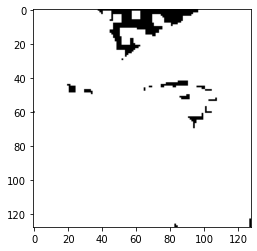

In [52]:
locMask = recon.getThresholdFromLoc(loc_r)
plt.imshow(locMask)


Load multi-freq matlab files. One set needs to be multi-channel process, so we add the magnitude channels here. |

In [53]:
mfr, mfrc = recon.loadMultiFrequencyFiles(currentPatient, freqAxis, multiCoilProcessing)

image array shape
(128, 128, 8, 3, 19)


This cell applies the MFI and frequency segmented recon based on the B0 map. One additional uncertainty is the global frequency shift accounting for errors in $\omega_C = \alpha \omega_H$. Therefore, the entire MFI is performed at a small search space in this list called "globalFreqSearch."   




In [54]:
mf, mfi, globalFreqSearch = recon.runMFI(globalFreqSearch, freqAxis, b0phase_r, locMask, mfr, mfrc, cjmat, multiCoilProcessing)


Here we pick the best global shift from the data. We use the peak signal from the bicarbonate to accopmplish this. In most cases, the first 2 bicarb images have no actual signal, but may contain a subtstantial artifact from pyruvate. Therefore these are filtered off. We look at several objective functions for choosing this frequency
* mean of an upper quantile, only within mask pixels
\begin{equation*}
\phi= \textrm{mean}(Q4(I(\mathbf{r})))\textrm{ s.t. } \mathbf{r}\in\textrm{mask} 
\end{equation*}

* mean of the absolute image gradient, only within mask pixels

\begin{equation*}
\phi= \textrm{mean}\left(\left|\nabla I(\mathbf{r})\right|\right)\textrm{ s.t. } \mathbf{r}\in\textrm{mask} 
\end{equation*}

* mean of the upper quantile of the absolute image gradient, only within mask pixels

\begin{equation*}
\phi= \textrm{mean}\left( Q4\left(\left|\nabla I(\mathbf{r})\right|\right)\right)\textrm{ s.t. } \mathbf{r}\in\textrm{mask} 
\end{equation*}

In [55]:
print(mf.shape)
print(mfi.shape[2])
print(mfr.shape)


(128, 128, 8, 3, 7)
8
(128, 128, 8, 3, 19)


In [56]:

kernelSize = 3



    
maskPixels = np.squeeze(sitk.GetArrayFromImage(mask_r))
peakTime = validate.findPeakSignalImages(mfi, maskPixels, globalOnResInd)                          
print('peak signal time indices: '+str(peakTime))

peak signal time indices: [4. 2. 1.]


In [57]:

peakSignalUncorr, peakSignalMFI, peakSignalSeg = validate.applyObjectiveMetric(freqAxis,globalFreqSearch, mfr, mfi, mf, peakTime, maskPixels)

im = 2  # which met to optimize on  
bestGlobalShiftUncorr = np.argmax(peakSignalUncorr[im,:])    
bestGlobalShift       = np.argmax(peakSignalSeg[im,:])

print('best global shift is at '+str(globalFreqSearch[bestGlobalShift])+' Hz')
print('best global shift-only is at '+str(globalFreqSearch[bestGlobalShiftUncorr])+' Hz')


# no correction
img_unc = np.abs(np.squeeze(mfr[:, :, :, :, onResInd]))
#global shift only 
img_gs = np.abs(np.squeeze(mfr[:, :, :, :, cdg.closestIndex(globalFreqSearch[bestGlobalShift], freqAxis)]))
#global shift + freq segmented
img_seg = np.abs(np.squeeze(mf[:,:,:,:,bestGlobalShift]))
#global shift + MFI
img_mfi = np.abs(np.squeeze(mfi[:,:,:,:,bestGlobalShift]))


best global shift is at 5.0 Hz
best global shift-only is at 5.0 Hz


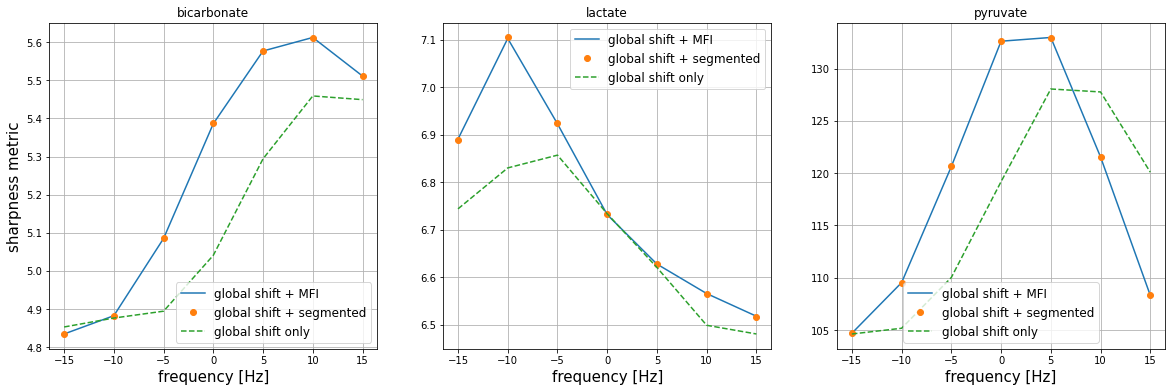

In [58]:
fs = 15


    
    
fig2, axes2 = plt.subplots(1, 3, figsize=(20,6))
titles = ['bicarbonate','lactate','pyruvate']
for x in range(0, 3): 
    axes2[x].plot(globalFreqSearch, peakSignalMFI[x,:], '-', label='global shift + MFI')
    axes2[x].plot(globalFreqSearch, peakSignalSeg[x,:], 'o',label='global shift + segmented')
    axes2[x].plot(globalFreqSearch, peakSignalUncorr[x,:], '--',label='global shift only')
    axes2[x].legend(fontsize=12)
    axes2[x].grid(True)
    axes2[x].set_xlabel('frequency [Hz]', fontsize=fs)
    axes2[x].set_title(titles[x])
axes2[0].set_ylabel('sharpness metric', fontsize=fs)





fig2.savefig('rawFigs/sharpnessMeasure.pdf')


compare corrected to uncorrected

Text(0.5, 1.0, 'MFI')

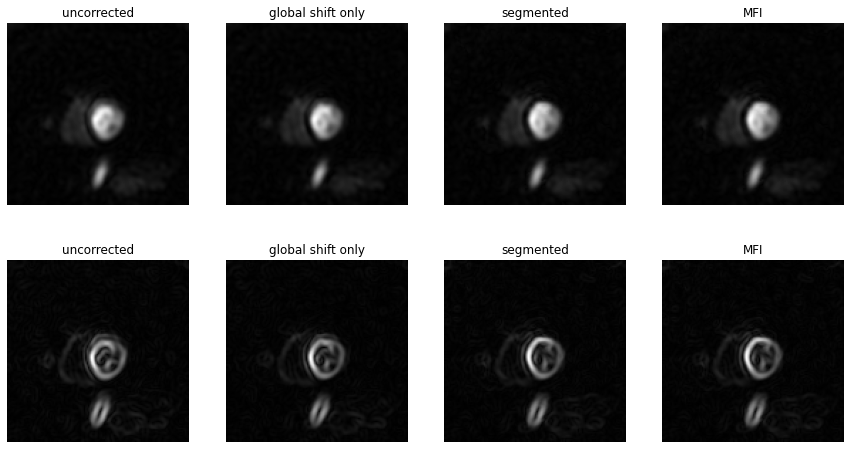

In [59]:
im = 2
it = 2



fig, ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8)) = plt.subplots(2,4,figsize=(15,8))
ax1.imshow(img_unc[:,:,it,im] , cmap='gray')
ax1.axis('off')
ax1.set_title('uncorrected')

ax2.imshow(img_gs[:,:,it,im], cmap='gray')
ax2.axis('off')
ax2.set_title('global shift only')

ax3.imshow(img_seg[:,:,it,im], cmap='gray')
ax3.axis('off')
ax3.set_title('segmented')

ax4.imshow(img_mfi[:,:,it,im], cmap='gray')
ax4.axis('off')
ax4.set_title('MFI')



ax5.imshow(validate.imageGrad(img_unc[:,:,it,im], kernelSize) , cmap='gray')
ax5.axis('off')
ax5.set_title('uncorrected')

ax6.imshow(validate.imageGrad(img_gs[:,:,it,im], kernelSize), cmap='gray')
ax6.axis('off')
ax6.set_title('global shift only')

ax7.imshow(validate.imageGrad(img_seg[:,:,it,im], kernelSize), cmap='gray')
ax7.axis('off')
ax7.set_title('segmented')

ax8.imshow(validate.imageGrad(img_mfi[:,:,it,im], kernelSize), cmap='gray')
ax8.axis('off')
ax8.set_title('MFI')




In [60]:


dicomKey = 'ImagingFrequency'
keys = loc.GetMetaDataKeys()
h1freq = float(b0mag.GetMetaData('0018|0084'))
c13FreqAdjustment = globalFreqSearch[bestGlobalShift] * 1e-6
c13freq = float(c13.GetMetaData('0018|0084'))

print('1H freq (dicom header) = '+ str(h1freq))
print('13C freq (dicom header) = '+ str(c13freq))
print('13C freq adjustment (from reconstruction) = '+ str(c13FreqAdjustment))

ratio = (c13freq+c13FreqAdjustment)/h1freq
print('ratio = '+str(ratio))




1H freq (dicom header) = 127.736282
13C freq (dicom header) = 32.12431
13C freq adjustment (from reconstruction) = 4.9999999999999996e-06
ratio = 0.2514893536669558


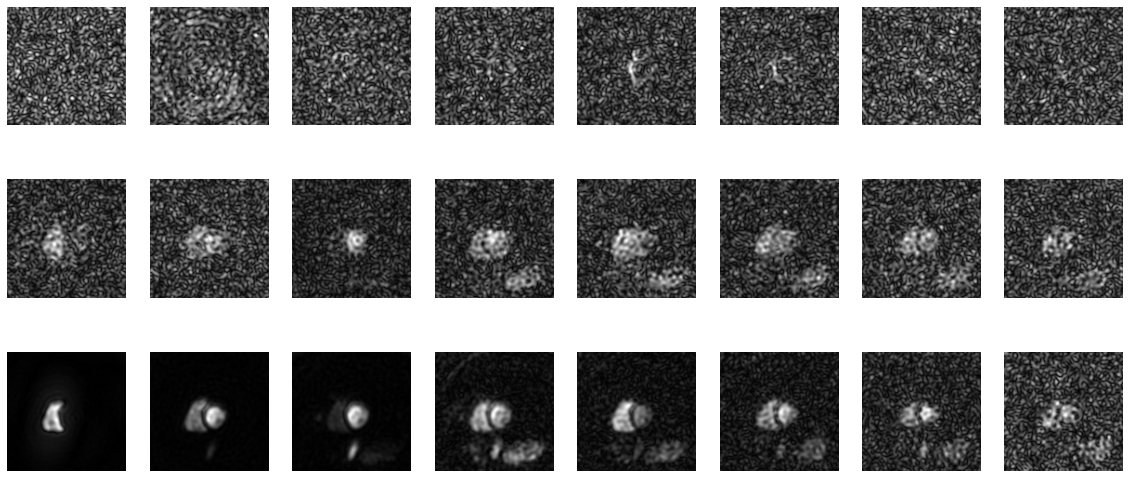

In [61]:
cdg.plotC13Mat(img_unc)

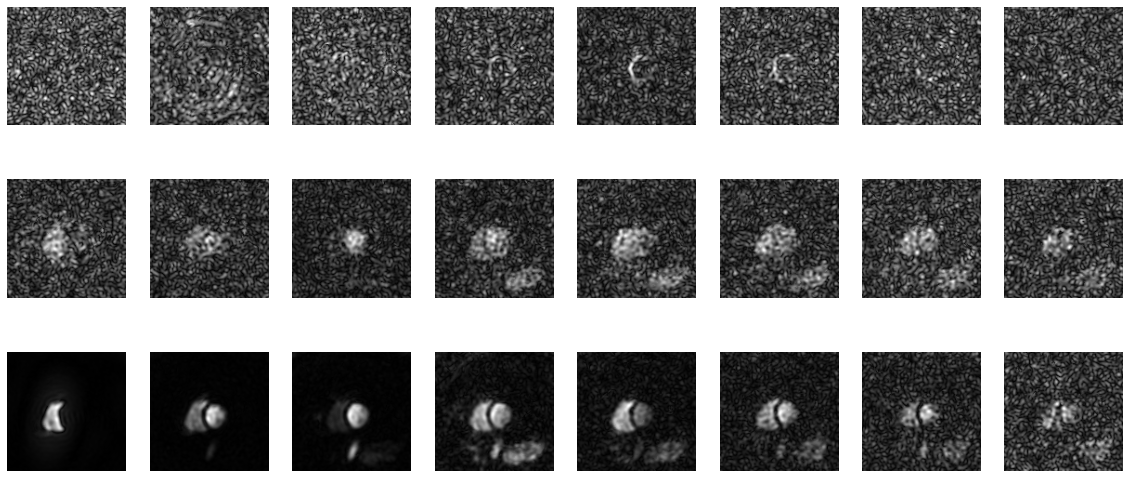

In [62]:
cdg.plotC13Mat(img_mfi)

Save corrected images at mat file

In [63]:
fileDict = dict()
fileDict["img_unc"] = img_unc
fileDict['img_gs'] = img_gs
fileDict['img_seg'] = img_seg
fileDict['img_mfi '] = img_mfi 
fileDict['h1freq'] = h1freq
fileDict['c13freq'] = c13freq
fileDict['globalFreqSearch'] = globalFreqSearch
fileDict['peakSignalUncorr'] = peakSignalUncorr
fileDict['peakSignalSeg'] = peakSignalSeg
fileDict['peakSignalMFI'] = peakSignalMFI
fileDict['freqAxis'] = freqAxis

outFileName = "B0CorrectedImages/"+currentPatient.mfr+".mat"
savemat(outFileName, fileDict)
